<a href="https://colab.research.google.com/github/multikokoiti1998/vgg_8_3/blob/MobileNet/Mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm
import random
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from pathlib import Path
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.optim as optim
import albumentations as A
from sklearn.metrics import classification_report

In [4]:
# 画像ディレクトリと画像パスの取得
image_directory = '/content/drive/MyDrive/lernig/obiref88/image'
label_directory = '/content/drive/MyDrive/lernig/obiref88/label'

def update_xml_paths(image_directory: str, label_directory: str):
    image_paths = []
    labels = []

    # 画像ファイルとXMLファイルの一致確認
    for image_file in os.listdir(image_directory):
        if image_file.endswith('.jpg'):
            base_name = image_file.replace('.jpg', '')

            xml_path = Path(label_directory) / f"{base_name}.xml"

            if xml_path.exists():
                tree = ET.parse(xml_path)
                root = tree.getroot()
                label = root.find('.//name')
                image_paths.append(os.path.join(image_directory, image_file))
                labels.append(label.text)

    return image_paths, labels

image_paths, labels = update_xml_paths(image_directory, label_directory)
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))


Number of image paths: 300
Number of labels: 300


In [5]:
data_transform = {
    'train': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
         transforms.RandomRotation(degrees=[-5, 5]),
         transforms.ColorJitter(brightness=0.3, contrast=0.5),
         #A.GaussNoise(var_limit=(10, 50))transformライブラリでないので変換前後で定義しなおさなくてはならない,
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ]),
    'val': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ])
}



In [6]:
label_mapping = {
    'ok': 0,
    'out': 1
}
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_mapping[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            label=torch.tensor(label)
        return image, label


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
num_epochs=200
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dataset=[]
val_dataset=[]
total_train_accs=[]
total_val_accs=[]
data_size = {'train': len(train_dataset), 'val': len(val_dataset)}

In [9]:
def train_model(model, criterion, optimizer, num_epochs):

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / data_size[phase]
                epoch_acc = corrects.double() / data_size[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              #print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
        val_accs_cpu = [acc.cpu().numpy() for acc in val_accs]

        plot_training_history(train_losses, val_losses, train_accs_cpu, val_accs_cpu)



def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Lossのプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()


In [10]:
net = models.mobilenet_v2(pretrained=True)

#for param in net.parameters():
          #param.requires_grad = False

# モデルをGPUに移動

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 損失関数と最適化アルゴリズムを定義(MSE）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
# モデルのトレーニングと評価
model = net
base_path = r'/content/drive/MyDrive/learning'
folder_name = 'weight'
directory_path = os.path.join(base_path, folder_name)
file_name = 'alexnet.pth'
file_path = os.path.join(base_path, folder_name, file_name)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 111MB/s] 


In [11]:
print("Length of image_paths:", len(image_paths))
print("Length of labels:", len(labels))

Length of image_paths: 300
Length of labels: 300


==========Cross Validation Fold 1==========
trainLoss: 0.9520 Acc: 0.2458
valLoss: 0.8000 Acc: 0.2333
trainLoss: 0.9650 Acc: 0.2833
valLoss: 0.8530 Acc: 0.2167
trainLoss: 0.9649 Acc: 0.2625
valLoss: 0.8055 Acc: 0.2833
trainLoss: 0.9292 Acc: 0.2708
valLoss: 0.8467 Acc: 0.2167
trainLoss: 0.9242 Acc: 0.2875
valLoss: 0.8491 Acc: 0.2333
trainLoss: 0.9306 Acc: 0.2667
valLoss: 0.8456 Acc: 0.2333
trainLoss: 0.9066 Acc: 0.3042
valLoss: 0.7800 Acc: 0.3333
trainLoss: 0.9145 Acc: 0.2833
valLoss: 0.8501 Acc: 0.2500
trainLoss: 0.9003 Acc: 0.3083
valLoss: 0.7593 Acc: 0.4167
trainLoss: 0.8963 Acc: 0.3000
valLoss: 0.7460 Acc: 0.4833
trainLoss: 0.8646 Acc: 0.3458
valLoss: 0.7673 Acc: 0.3833
trainLoss: 0.8764 Acc: 0.3292
valLoss: 0.7291 Acc: 0.5000
trainLoss: 0.8905 Acc: 0.3333
valLoss: 0.7279 Acc: 0.4667
trainLoss: 0.8659 Acc: 0.3333
valLoss: 0.7980 Acc: 0.3833
trainLoss: 0.8674 Acc: 0.3458
valLoss: 0.7043 Acc: 0.5500
trainLoss: 0.8748 Acc: 0.3375
valLoss: 0.7141 Acc: 0.5167
trainLoss: 0.8456 Acc: 0.383

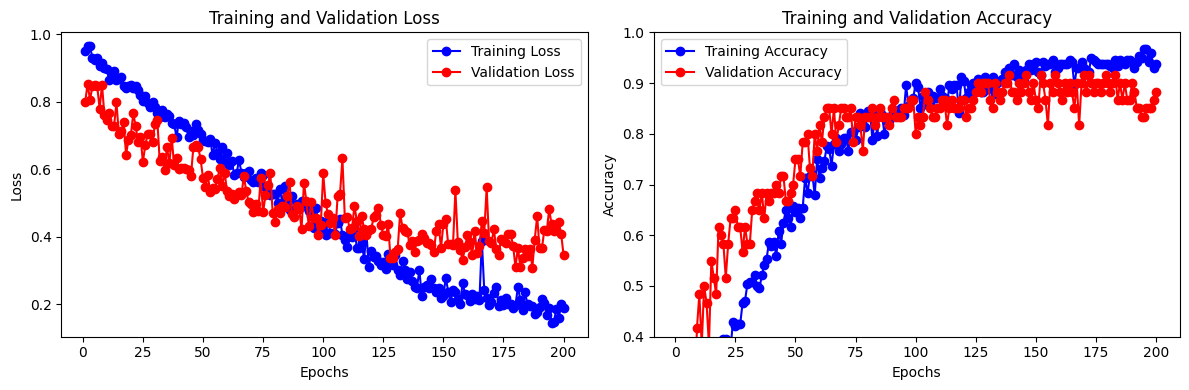

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.93      0.91      0.92        47
         out       0.71      0.77      0.74        13

    accuracy                           0.88        60
   macro avg       0.82      0.84      0.83        60
weighted avg       0.89      0.88      0.88        60

==========Cross Validation Fold 2==========
trainLoss: 0.5901 Acc: 0.7500
valLoss: 0.5019 Acc: 0.9667
trainLoss: 0.5231 Acc: 0.8333
valLoss: 0.4413 Acc: 0.9833
trainLoss: 0.4676 Acc: 0.8708
valLoss: 0.4070 Acc: 1.0000
trainLoss: 0.4515 Acc: 0.8750
valLoss: 0.3735 Acc: 1.0000
trainLoss: 0.4154 Acc: 0.8917
valLoss: 0.3455 Acc: 1.0000
trainLoss: 0.3882 Acc: 0.9083
valLoss: 0.3220 Acc: 1.0000
trainLoss: 0.3776 Acc: 0.9250
valLoss: 0.2997 Acc: 1.0000
trainLoss: 0.3798 Acc: 0.8833
valLoss: 0.2875 Acc: 1.0000
trainLoss: 0.3502 Acc: 0.9250
valLoss: 0.2728 Acc: 1.0000
trainLoss: 0.3356 Acc: 0.9292
valLoss: 0.2750 Acc: 1.0000
trainLoss: 0.3178 Acc: 0

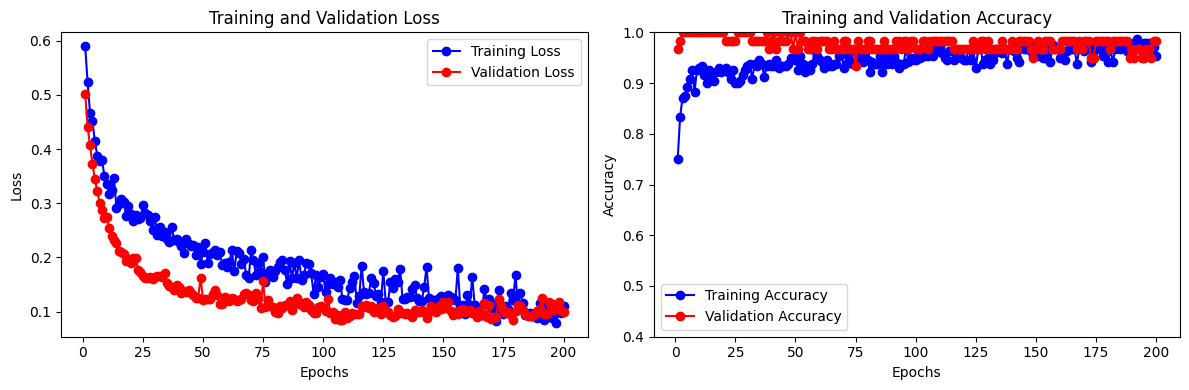

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      1.00      0.99        48
         out       1.00      0.92      0.96        12

    accuracy                           0.98        60
   macro avg       0.99      0.96      0.97        60
weighted avg       0.98      0.98      0.98        60

==========Cross Validation Fold 3==========
trainLoss: 0.5921 Acc: 0.7500
valLoss: 0.4764 Acc: 0.9500
trainLoss: 0.5237 Acc: 0.8875
valLoss: 0.4138 Acc: 0.9833
trainLoss: 0.4912 Acc: 0.9125
valLoss: 0.3751 Acc: 0.9833
trainLoss: 0.4448 Acc: 0.9458
valLoss: 0.3378 Acc: 0.9833
trainLoss: 0.4272 Acc: 0.9417
valLoss: 0.3138 Acc: 0.9667
trainLoss: 0.3937 Acc: 0.9375
valLoss: 0.2934 Acc: 0.9667
trainLoss: 0.3735 Acc: 0.9417
valLoss: 0.2694 Acc: 0.9667
trainLoss: 0.3476 Acc: 0.9500
valLoss: 0.2597 Acc: 0.9667
trainLoss: 0.3087 Acc: 0.9792
valLoss: 0.2495 Acc: 0.9667
trainLoss: 0.3164 Acc: 0.9625
valLoss: 0.2311 Acc: 0.9667
trainLoss: 0.2970 Acc: 0

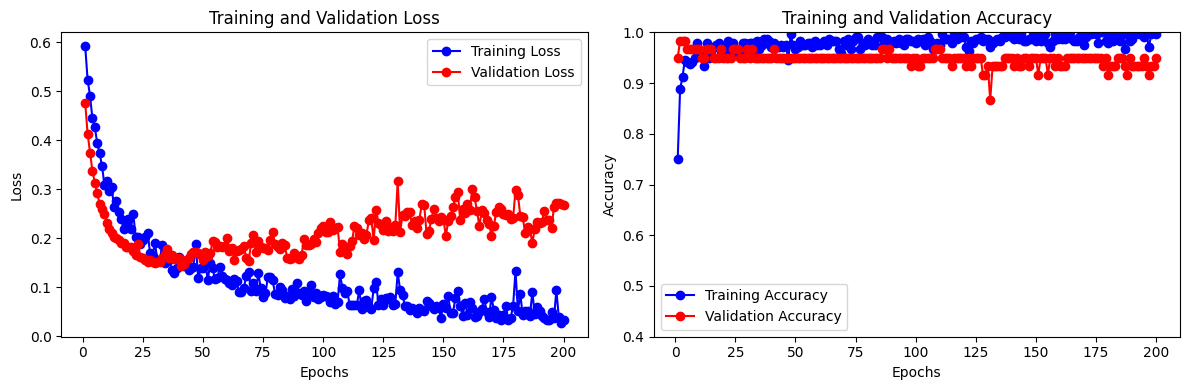

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      0.95      0.96        42
         out       0.89      0.94      0.92        18

    accuracy                           0.95        60
   macro avg       0.94      0.95      0.94        60
weighted avg       0.95      0.95      0.95        60

==========Cross Validation Fold 4==========
trainLoss: 0.7052 Acc: 0.3542
valLoss: 0.6419 Acc: 0.3000
trainLoss: 0.6212 Acc: 0.5542
valLoss: 0.5688 Acc: 0.4667
trainLoss: 0.5499 Acc: 0.7792
valLoss: 0.5046 Acc: 0.7667
trainLoss: 0.4977 Acc: 0.8500
valLoss: 0.4578 Acc: 0.9667
trainLoss: 0.4562 Acc: 0.9250
valLoss: 0.4109 Acc: 0.9833
trainLoss: 0.4379 Acc: 0.9500
valLoss: 0.3830 Acc: 0.9833
trainLoss: 0.3885 Acc: 0.9583
valLoss: 0.3424 Acc: 0.9833
trainLoss: 0.3727 Acc: 0.9417
valLoss: 0.3131 Acc: 1.0000
trainLoss: 0.3363 Acc: 0.9625
valLoss: 0.2930 Acc: 1.0000
trainLoss: 0.3280 Acc: 0.9625
valLoss: 0.2722 Acc: 1.0000
trainLoss: 0.3044 Acc: 0

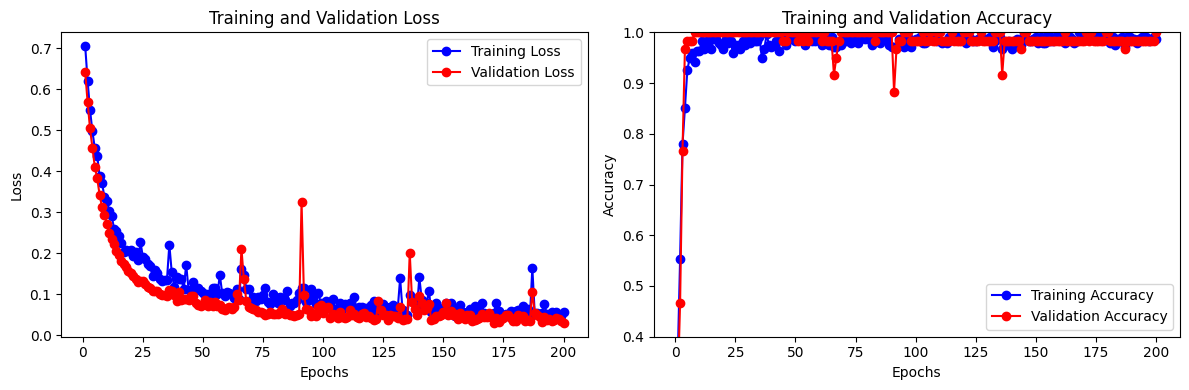

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       1.00      1.00      1.00        44
         out       1.00      1.00      1.00        16

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

==========Cross Validation Fold 5==========
trainLoss: 0.6725 Acc: 0.5292
valLoss: 0.5825 Acc: 0.8667
trainLoss: 0.5919 Acc: 0.7667
valLoss: 0.4900 Acc: 0.9667
trainLoss: 0.5051 Acc: 0.8958
valLoss: 0.4238 Acc: 0.9667
trainLoss: 0.4418 Acc: 0.9792
valLoss: 0.3754 Acc: 0.9667
trainLoss: 0.3949 Acc: 0.9750
valLoss: 0.3333 Acc: 0.9667
trainLoss: 0.3786 Acc: 0.9750
valLoss: 0.3022 Acc: 0.9667
trainLoss: 0.3298 Acc: 0.9917
valLoss: 0.2786 Acc: 0.9667
trainLoss: 0.3189 Acc: 0.9708
valLoss: 0.2629 Acc: 0.9833
trainLoss: 0.2951 Acc: 0.9792
valLoss: 0.2369 Acc: 0.9833
trainLoss: 0.2815 Acc: 0.9875
valLoss: 0.2234 Acc: 0.9833
trainLoss: 0.2513 Acc: 0

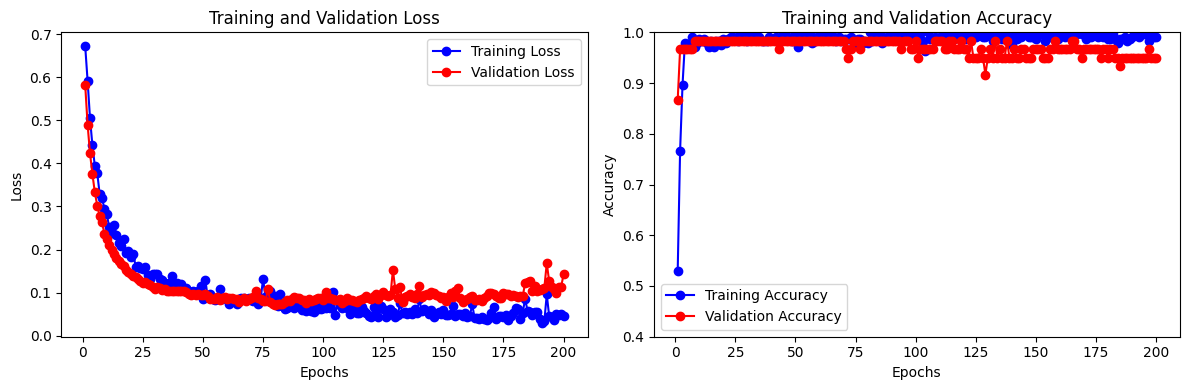

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.94      1.00      0.97        45
         out       1.00      0.80      0.89        15

    accuracy                           0.95        60
   macro avg       0.97      0.90      0.93        60
weighted avg       0.95      0.95      0.95        60



In [12]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# データセットの分割とデータローダーの作成
for fold, (train_index, val_index) in enumerate(kfold.split(image_paths,labels), 1):
    print(f'==========Cross Validation Fold {fold}==========')
    image_directory = '/content/drive/MyDrive/lernig/OBI_ref/image'
    label_directory = '/content/drive/MyDrive/lernig/OBI_ref/label'


    image_paths, labels = update_xml_paths(image_directory, label_directory)
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = ImageDataset(train_paths, train_labels, transform=data_transform['train'])
    val_dataset = ImageDataset(val_paths, val_labels, transform=data_transform['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    dataloaders  = {"train":train_loader, "val":val_loader}

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # 事前学習済みモデルの全結合層の出力ユニット数をデータのクラス数に置き換え
    num_classes = len(set(train_labels))
    net.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=2)


# ここでデータローダーを使用して学習や検証を行う
    data_size = {'train': len(train_dataset), 'val': len(val_dataset)}
    train_model(model, criterion, optimizer, num_epochs)
    print('Train done.')
    file_path = os.path.join(directory_path, f'{file_name}_{str(fold)}.pth')
    # モデルの保存
    torch.save(model.state_dict(), file_path)
    print('Train saved.')
    model.load_state_dict(torch.load(file_path))
    model.eval()
    model.to(device)

    y_pred = []
    y_true = []
    with torch.no_grad():
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())

    # 評価
    target_names = ['ok', 'out']  # クラス名をリストで指定
    print(classification_report(y_true, y_pred, target_names=target_names))